In [9]:
import os
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
from mtspec import mtspec
from obspy.core import UTCDateTime
from obspy import read, read_inventory, Stream
from obspy.signal.freqattributes import peak_ground_motion

In [18]:
from read_arrival import pick_arrival, distances
from plots import plot_traces, plot_windows
from cut_signal import *
from spectra import calc_spectra, differentiate, bin_spectrum
from snr_calc import calc_bsnr, find_freq_limit

/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


original continuous record


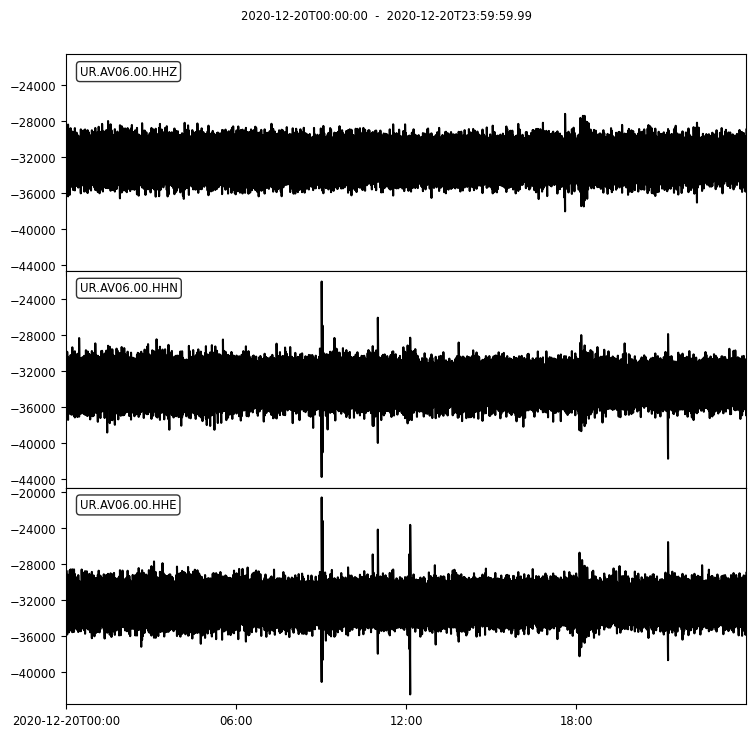

In [6]:
#1. Read catalog.csv
path ="/Volumes/Samsung_T5/Secondment_GFZ"
catalog ="Catalog.csv"
df = pd.read_csv(os.path.join(path,catalog))
# newid = "GB.WACR_2021-12-27 02:15:09.400"
# newid = "UR.AQ04_2019-06-21 23:33:05.800"
newid ="UR.AV06_2020-12-20 21:13:22.200"
#Define directory of stations and events inventory
pinv  = "/Users/psuroyo/Documents/Study_DataWork/PNR_TLS_Array/selected_mseed_p/Inventory/"
inv = read_inventory(os.path.join(pinv,'pnr_inventory.xml'),'stationxml')

#2. find 1 event recorded in 1 station from all channels
df['newid'] = df['network']+"."+df['station']+"_"+df["eventid"]
        
#3. find all channel which record one single event in one station
dsameid = df[(df['newid'] == newid)] 
    
#4. take p-time and s-time
ptime= pick_arrival(dsameid, "P")
stime= pick_arrival(dsameid, "S")
repi, rhyp = distances(dsameid)

#5. find the continuous waveform and join as one stream
loc_path = "/Volumes/Samsung_T5/Secondment_GFZ/continuous"
if len(dsameid)> 3: 
    dsameid = dsameid.drop_duplicates(subset=['continuous id'], keep='first')
    
st = Stream()
for i in range(len(dsameid)):
    d = dsameid.iloc[i]
    year = d["continuous id"].split(".")[5]
    sta = d['station']
    net = d['network']
    cha = d['channel']
    otime = d['otime']
    recpath = os.path.join(loc_path, year, net, sta)
    recfile = net+ "."+ sta+ ".00."+ cha+ d['eventid']
    s = read (os.path.join(recpath,recfile), format='mseed')
    if len(s) == 1:
        st.append(s[0])
    else:
        print("input should be one single trace!")

print("original continuous record")
st.plot()
#6. trimming signal from 
if rhyp < 150:
    buff_start = 60.0
    buff_end = 3*60.0
else:
    buff_start = 60.0 + ((rhyp - 150 )/ 8.3)
    buff_end = 3*60.0 + ((rhyp - 150 )/ 8.3)

ptime = UTCDateTime(ptime)
stime = UTCDateTime (stime)
otime = UTCDateTime (otime)
start = ptime - buff_start
end = ptime + buff_end


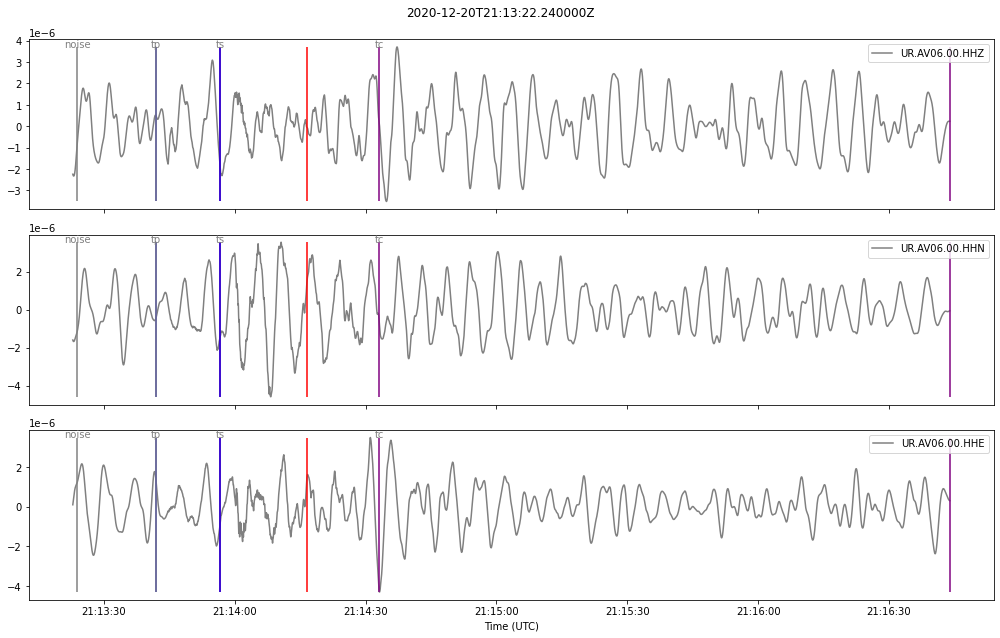

In [7]:
st_ = st.copy()
st_.trim(start, end, pad=True)
#7. update metadata with ptime, stime, distances 
for tr in st_:
    tr.stats['p_time'] = ptime
    tr.stats['s_time'] = stime
    tr.stats['repi_km'] = repi
    tr.stats['rhyp_km'] = rhyp
    tr.stats['otime'] = otime
    tr.stats['wstart'] = start
    tr.stats['wend'] = end


# plot_traces(st_, plot_theoreticals=True, plot_windows=False, conv=1)
#8. store earthquake recordings 
#9. signal processing 
    # cut P window, S window, and coda window 
pwave = get_signal(st_, cut_p)
swave = get_signal(st_, cut_s)
cwave = get_signal(st_, cut_c, bf=2, raf=0.8, tafp=2.3)
noisewave= get_noise_s(st_, swave, "pre")


#10. detrend, pre-filter & instrumetal correction
stc= st_.copy()
for tr,tn in zip(stc, noisewave):
    tr.detrend('demean')
    tr.remove_response(inv, pre_filt=[0.05,0.1,40,45], output="DISP")
    tn.detrend('demean')
    tn.remove_response(inv, pre_filt=[0.05,0.1,40,45], output="DISP")
    

plot_windows(stc, conv=1, bft=1, aftt=60,pwave=pwave, swave=swave,
                 cwave=cwave, noise=noisewave, save=None)

/Users/psuroyo/Documents/GitHub/code_signal_processing/spectra.py:54: RuntimeWarning: Mean of empty slice.
  a = 10**np.log10(amp[(freq>=bb)&(freq<=bf)]).mean()
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/psuroyo/Documents/GitHub/code_signal_processing/spectra.py:54: RuntimeWarning: Mean of empty slice.
  a = 10**np.log10(amp[(freq>=bb)&(freq<=bf)]).mean()
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/psuroyo/Documents/GitHub/code_signal_processing/spectra.py:54: RuntimeWarning: Mean of empty slice.
  a = 10**np.log10(amp[(freq>=bb)&(freq<=bf)]).mean()
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = 

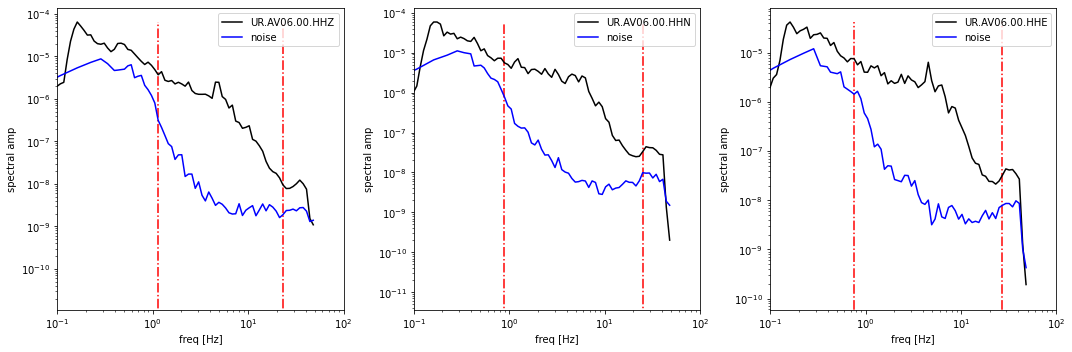

In [20]:
#11. calculate fourier spectra for noise and signal
BIN_PARS = {"smin": 0.001, "smax": 200, "bins": 151}
fig,ax = plt.subplots(1,3,figsize=(3*5,5))
for i, (tr, tn) in enumerate(zip(stc, noisewave)):
    samp, sfreq = calc_spectra(tr)
    namp, nfreq = calc_spectra(tn)
    samp= differentiate(samp,sfreq)
    namp= differentiate(namp,nfreq)
    bnamp, bnfreq = bin_spectrum(namp, nfreq, **BIN_PARS)
    bsamp, bsfreq = bin_spectrum(samp, sfreq, **BIN_PARS)
    ax[i].loglog(bsfreq,bsamp , 'k',label=tr.id)
    ax[i].loglog(bnfreq, bnamp, 'b',label='noise')
    ax[i].set_xlabel('freq [Hz]')
    ax[i].set_ylabel('spectral amp')
    ax[i].set_xlim(0.1,100)
    ax[i].legend()
    
#12. Signal to Noise Ratio
    snr = calc_bsnr(namp, nfreq, samp, sfreq, ROTATE_NOISE=True)
    fbands = find_freq_limit(bsfreq,snr,[.1,45.],3)
    ax[i].vlines(fbands[0], 0., bsamp.max(),color='r', linestyle='-.')
    ax[i].vlines(fbands[1], 0., bsamp.max(),color='r',linestyle='-.')
fig.tight_layout()

/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/opt/anaconda3/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


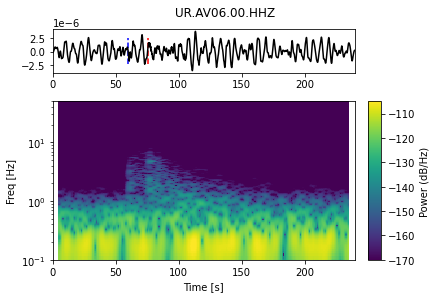

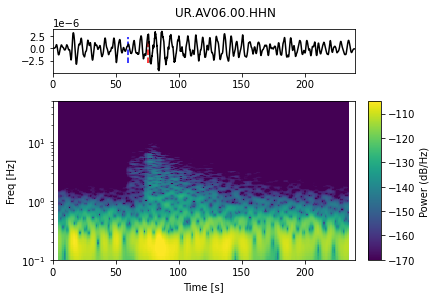

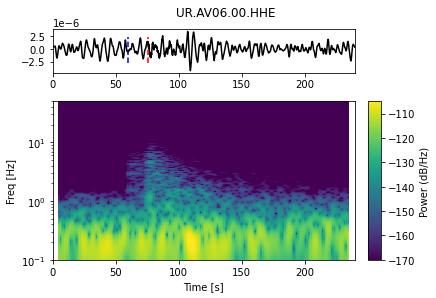

In [21]:
for tr in stc:
    fig = plt.figure()
    ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.15]) #[left bottom width height]
    ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.55], sharex=ax1)
    ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.55])
    #make time vector
    sps = int(tr.stats.sampling_rate)
    t = np.arange(tr.stats.npts) / tr.stats.sampling_rate
    ax1.plot(t, tr.copy().data, 'k')
    p = tr.stats['p_time']-tr.stats.starttime
    s = tr.stats['s_time']-tr.stats.starttime
    ax1.vlines(p, tr.data.min()/1.5, tr.data.max()/1.5,
        linestyles='dashed', color='blue', label='Pg')
    ax1.vlines(s, tr.data.min()/1.5, tr.data.max()/1.5,
        linestyles='dashed', color='red', label='Sg')
    tr.spectrogram(wlen=.1*sps, per_lap=0.90, dbscale=True,
        log=True, axes=ax2)#, cmap='YlOrRd')
    ax2.set_ylim((0.1,50))
    ax2.set_xlabel("Time [s]")
    ax2.set_ylabel("Freq [Hz]")
    ax2.collections[0].set_clim(vmin=-170, vmax=-105) # Find the quadmesh/pcolormesh created by the spectrogram call, and then change its clims
    mappable = ax2.collections[0]
    cb = plt.colorbar(mappable=mappable, cax=ax3, ticks=np.arange(-210,-100, 10))
    cb.set_label('Power (dB/Hz)') 
    fig.suptitle(tr.id)
    fig.tight_layout()

In [22]:
from scipy.integrate import cumtrapz
def get_arias(tr):
        """
        Performs calculation of arias intensity.
        Input should be in DISP
        Returns:
            arias_intensities.
        """

        trace= tr.copy()
        trace.differentiate # in m/s
        dt = trace.stats["delta"]
        # Calculate Arias Intensity
        arias_intensity =np.pi / (2 * 9.81) * cumtrapz(trace.data ** 2, dx=dt, initial=0)
        

        return arias_intensity

def calc_cav(tr):
    """
    Calculates the Cumulative Absolute velocity

    ref:
    Electrical Power Research Institute. Standardization of the Cumulative
    Absolute Velocity. 1991. EPRI TR-100082-1'2, Palo Alto, California.
    """
    from scipy.integrate import cumtrapz
    trace=tr.copy()
    trace.differentiate # in m/s 
    abs_acc = np.abs(trace.data)
    return cumtrapz(abs_acc, dx=trace.stats.delta, initial=0)


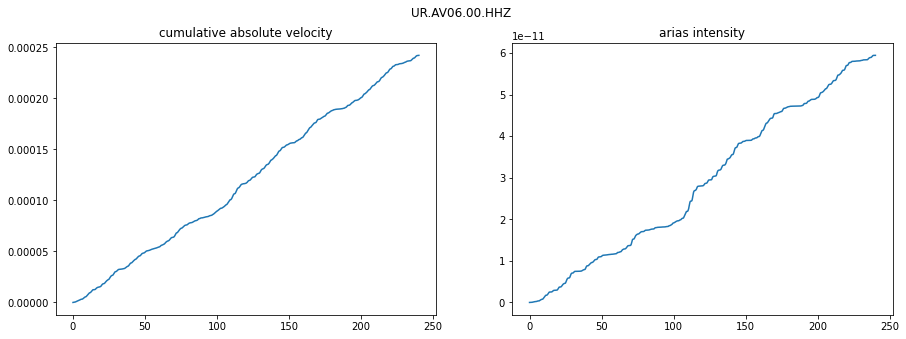

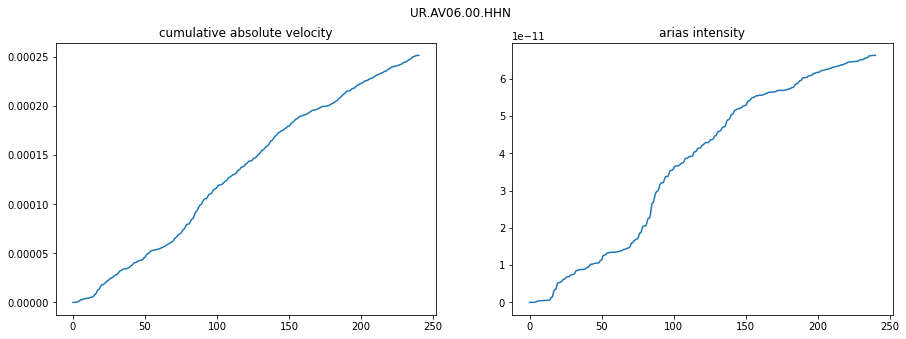

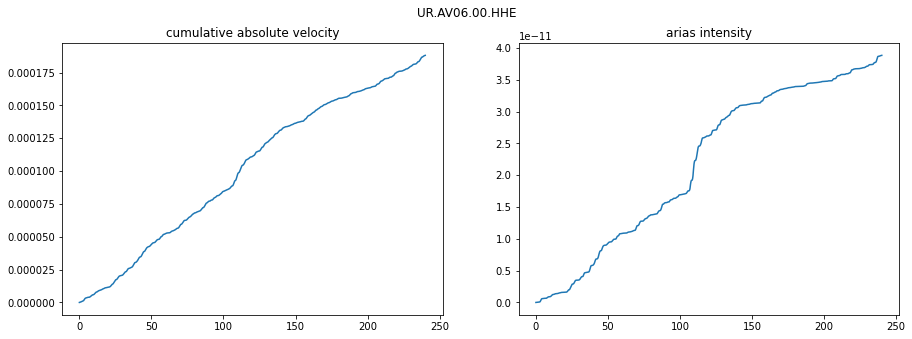

In [24]:
for tr in stc:
    fig, ax= plt.subplots(1,2,figsize=(3*5,5))
    arias = get_arias(tr)
    cav = calc_cav(tr)
    ax[0].plot(tr.times(),cav)
    ax[0].set_title("cumulative absolute velocity")
    ax[1].plot(tr.times(),arias)
    ax[1].set_title("arias intensity")
    fig.suptitle(tr.id)